In [58]:
# Imports, as always...
from random import choice
from tqdm.notebook import tqdm
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.gradients import ReverseEstimatorGradient

# Classical ML.
from sklearn.model_selection import train_test_split
from torch.nn import Module
from torch.utils.data import DataLoader
from torch import manual_seed

# QML.
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_qulacs.qulacs_estimator import QulacsEstimator
from qiskit_qulacs.qulacs_estimator_gradient import QulacsEstimatorGradient

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_machine_learning import __version__ as qml_version
from qiskit_algorithms import __version__ as alg_version
from qiskit_qulacs import __version__ as qulacs_version
from torch import __version__ as torch_version

# Plotting.
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

# Package versions (ignoring packages that obviously won't be a problem).
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit_machine_learning', qml_version), ('qiskit_algorithms', alg_version), ('qiskit_qulacs', qulacs_version), ('numpy', np.__version__), ('torch', torch_version)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')
    
# Random seed setting.
seed = 42
algorithm_globals.random_seed = seed
np.random.seed(seed)
manual_seed(seed)

Important Package Versions...

qiskit                  : 1.1.1
qiskit_machine_learning : 0.7.2
qiskit_algorithms       : 0.3.0
qiskit_qulacs           : 0.1.0
numpy                   : 1.24.3
torch                   : 2.3.1


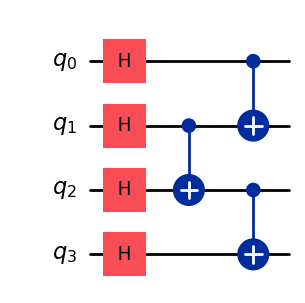

In [2]:
# Setting the unknown unitary to be learnt.
U = QuantumCircuit(4)
U.h(0), U.h(1), U.h(2), U.h(3)
U.cx(1, 2), U.cx(0, 1), U.cx(2, 3)

U.draw('mpl', style='iqp')

# Layerwise Learning for Local Inversion Unitaries

[This paper](https://link.springer.com/article/10.1007/s42484-020-00036-4) introduces "layerwise learning" for quantum machine learning, which incrementally adds layers to the ansatz during training and freezes parameters after some specified time in a bid to avoid all kinds of issues with barren plateaus. Seems like an interesting approach, and since we appear to be having a horrible time with unlearnable landscapes, it may be worth a shot.

## Dataset

Since we will be trying to learn a local inversion for a given unitary, we would quite like the input to be any arbitrary state with fairly equal probability so that no bias is picked up. Hence, our dataset should comprise randomly sampled $n$-qubit states, and should be large enough so that we can be happy that a good distribution of states is covered.

Also, concerning the implementation, our circuit will take as input two rotations, $\theta$ and $\phi$, per qubit and will make up the dataset, giving it the shape $N\times n\times2$, with $N$ the number of samples. How to sample angles so that they correspond to an even distribution of points on the unit sphere is an interesting question. [This paper](https://arxiv.org/pdf/0912.4540) considers this problem, in part, and gives us the idea to use the *Fibonacci sphere algorithm*. We can then use this to generate a set of angles from which to uniformly randomly sample and build up our dataset.

In [11]:
# Fibonacci sphere algorithm for sampling an even distribution of points on the unit sphere as a pair of angles.
# See https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
def sample_input_angles(n_points):
    # Define the golden angle in radians.
    golden_ratio = np.pi * (np.sqrt(5) - 1)
    
    angles = []
    for i in range(n_points):
        # Generate (x, y, z) co-ordinates.
        y = 1 - (i / (n_points - 1)) * 2
        r = np.sqrt(1 - y ** 2)
        x = np.cos(golden_ratio * i) * r
        z = np.sin(golden_ratio * i) * r
        
        # Convert to polar angles.
        theta = np.arctan2(y, x)
        phi = np.arccos(z)
        
        # Append.
        angles.append([theta, phi])
        
    # Return as a numpy array.
    return np.array(angles)

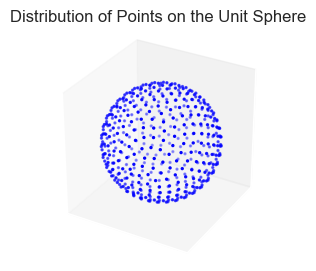

In [44]:
# Let's have a look at that then.

def plot_angles(angles):
    # Get Cartesian coordinates.
    theta = angles[:, 0]
    phi = angles[:, 1]
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    # Plot.
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o', s=1000/n_points)
    
    # Beautify.
    ax.set_title('Distribution of Points on the Unit Sphere')
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_facecolor('none')
    
    plt.show()
    
# Demo.
n_points = 500
angles = sample_input_angles(n_points)
plot_angles(angles)

In [63]:
# Build a dataset of N n-qubit states over an unbiased distribution.
def sample_xs(N, n, n_points=10000):
    # Generate the set of angles.
    angles = sample_input_angles(n_points)
    
    # Return N uniformly randomly sampled sets of angles.
    return np.array([
        angles[np.random.choice(angles.shape[0], size=n, replace=True)] for _ in range(N)
    ])

xs = sample_xs(N=5000, n=U.num_qubits)

In [64]:
# Train test split.
test_size, val_size = .25, .15
xs_train, xs_test = train_test_split(xs, test_size=test_size, shuffle=True)
xs_train, xs_val = train_test_split(xs, test_size=val_size, shuffle=True)

# Into Dataloaders.
batch_size = 16
n_workers = 1
train_dataloader = DataLoader(xs_train, shuffle=True, batch_size=batch_size, num_workers=n_workers)
val_dataloader = DataLoader(xs_val, shuffle=True, batch_size=batch_size, num_workers=n_workers)
test_dataloader = DataLoader(xs_test, shuffle=True, batch_size=batch_size, num_workers=n_workers)

## Circuit

Our circuit is as before: a parameterisation on the inputs (as two distinct rotations), which is set up so that each qubit in the target set $S$ is replicated (for later comparison), as well as an auxiliary qubit in $|0\rangle$, then followed by the application of $U$ then $V(\theta_S)$ on the first $n$ qubits, and finally a SWAP test between the qubits in $S$ and their replicated counterparts (used for a loss approximating the similarity between the true input $|\psi_S\rangle$ on the qubits in $S$ and the recovered input $(V(\theta_S)U|\psi\rangle)_S$ from the local inversion). 

The output from the circuit is a single classical bit $0/1$. With $O(1/\varepsilon^2)$ shots, the probability to sample $1$ corresponds to the loss we look to minimise, and allows us to approximate the squared inner product to within $\varepsilon$ additive error. See [the wikipedia entry for the SWAP test](https://en.wikipedia.org/wiki/Swap_test) for more detail.

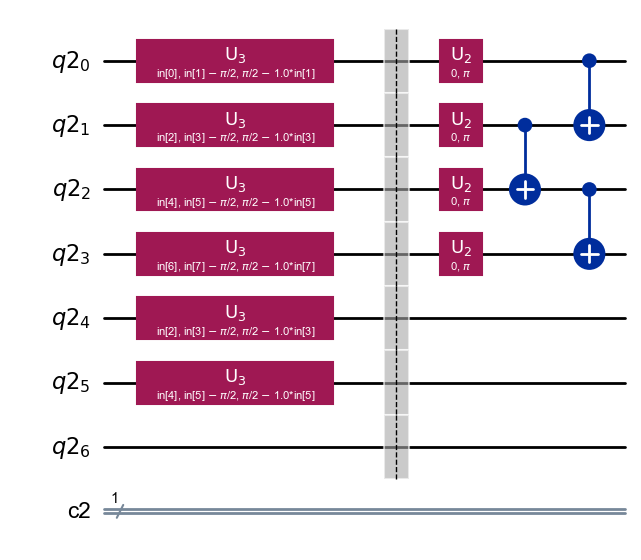

In [68]:
# Generate a feature map using the unitary U and targeting the qubits in S.
def generate_feature_map(U, S):
    # Instantiate a new circuit with classical register for measurement.
    q_reg = QuantumRegister(U.num_qubits + len(S) + 1)
    c_reg = ClassicalRegister(1)
    circuit = QuantumCircuit(q_reg, c_reg)
    
    # Prepare an input state (parameterised) consistent between the two sets of qubits.
    input_parameters = ParameterVector('in', 2 * U.num_qubits)
    for i in range(U.num_qubits):
        circuit.r(theta=input_parameters[2 * i], phi=input_parameters[2 * i + 1], qubit=i)
        if i in S: circuit.r(theta=input_parameters[2 * i], phi=input_parameters[2 * i + 1], qubit=U.num_qubits + i - 1)
        
    # Barrier for clarity.
    circuit.barrier()
        
    # Add U.
    U_copy = U.copy()
    circuit.compose(U_copy, inplace=True)
    
    return circuit
    
# Feature map and input parameters.
S = [1, 2]
feature_map = generate_feature_map(U, S)
input_parameters = feature_map.parameters

# Let's have a look.
feature_map.decompose().draw('mpl', style='iqp')

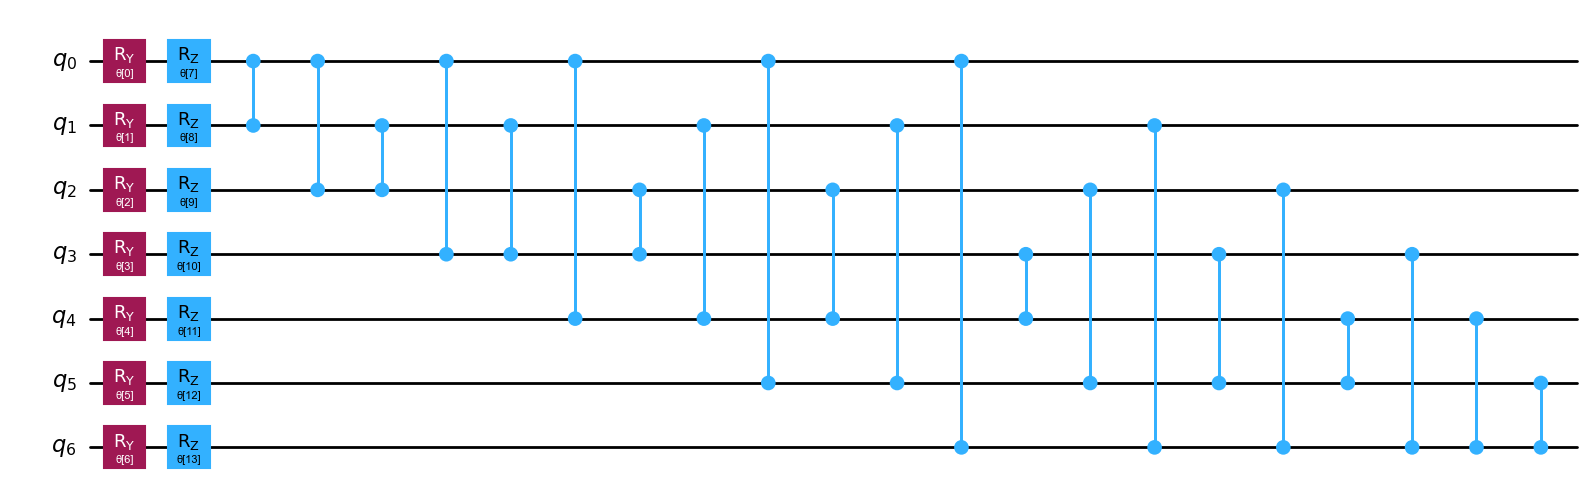

In [71]:
# Ansatz and weight parameters.
ansatz = TwoLocal(
    num_qubits = U.num_qubits + len(S) + 1,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks=['cz'],
    entanglement='full',
    reps=1,
    skip_final_rotation_layer=True
).decompose()
weight_parameters = ansatz.parameters

# Let's have a look.
ansatz.draw('mpl', style='iqp')

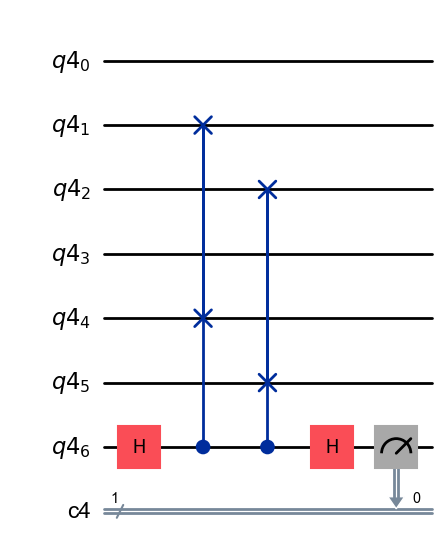

In [73]:
# generate a SWAP test for the target qubits.
def generate_swap_test(n, S):
    # Instantiate a new circuit with classical register for measurement.
    q_reg = QuantumRegister(n + len(S) + 1)
    c_reg = ClassicalRegister(1)
    circuit = QuantumCircuit(q_reg, c_reg)
    
    aux_idx = circuit.num_qubits - 1
    circuit.h(aux_idx)
    
    for i, q in enumerate(S):
        circuit.cswap(control_qubit=aux_idx, target_qubit1=q, target_qubit2=U.num_qubits+i)
        
    circuit.h(aux_idx)
    circuit.measure(aux_idx, c_reg[0])
    
    return circuit
    
# SWAP test.
swap_test = generate_swap_test(U.num_qubits, S)

# Let's have a look.
swap_test.draw('mpl', style='iqp')

## Model

We'll use `TorchConnector` to bundle Qiskit's QNN object into a PyTorch neural network module that we can train in the usual way (hopefully). The caveat is that the network won't actually be predicting anything, but instead will be spitting out a loss that tells us how well its learnt structure is local inverting $U$. In that sense, there is nothing to predict, so the forward pass is a little redundant. Nonetheless, we use it anyway.

In [65]:
class QNNModel(Module):
    def __init__(self, qnn):
        super().__init__()
        self.qnn = TorchConnector(qnn)
        
    def forward(self, x):
        # Loss is the probability to measure |1>. Over a batch, this is the mean probability.
        return np.mean(self.qnn(x)[:, 1])